# TP1: The Multi layer perceptron
### The First Deep Learning Model
#### By: Alexandre Verine

In this practical work, we will implement a simple neural network with two hidden layers. We will use the relu activation function for the hidden layer and the softmax activation function for the output layer. We will use the cross-entropy loss as the loss function. We will use the backpropagation algorithm to train the model. We will use the MNIST dataset to train and test the model.

First, we load the necessary libraries:

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:

import torch  # PyTorch library, provides tensor computation and deep neural networks
import torchvision  # Package that provides access to popular datasets, model architectures, and image transformations for computer vision
import torch.nn as nn  # Provides classes to define and manipulate neural networks
import torch.nn.functional as F  # Contains functions that do not have any parameters, such as relu, tanh, etc.
import torch.optim as optim  # Package implementing various optimization algorithms - used to update the parameters of your network

import numpy as np  # Library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import matplotlib.pyplot as plt  # Library for creating static, animated, and interactive visualizations in Python

from torchview import draw_graph  # Library for visualizing PyTorch computation graphs

We set the main hyperparameters of the training algorithm:

In [3]:
n_epochs = 5 # Number of epochs to train the model
batch_size_train = 100 # Number of training examples utilized in one iteration
batch_size_test = 10000 # Number of test examples utilized in one iteration
learning_rate = 5e-4 # Learning rate for the optimizer
log_interval = 100 # Number of batches to wait before logging training status

random_seed = 1 # Random seed for reproducibility
torch.backends.cudnn.enabled = False # Disables cuDNN for reproducibility
torch.manual_seed(random_seed); # Sets the seed for generating random numbers

We load the MNIST dataset:

In [4]:
transform = torchvision.transforms.Compose([  # Preprocessing the data
    torchvision.transforms.ToTensor(),  # Converts the image to a tensor
    torchvision.transforms.Normalize((0.1307,), (0.3081,))  # Normalizes the image
])

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data/', train=True, download=True,transform=transform),  # Loads the MNIST dataset and creates a DataLoader
  batch_size=batch_size_train, shuffle=True)   # Number of training examples utilized in one iteration, shuffles the data after every epoch

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data/', train=False, download=True, transform=transform),  # Loads the MNIST dataset and creates a DataLoader
  batch_size=batch_size_test, shuffle=False)

We can observe the first batch of the dataset. Every time the object *train_loader* is called, it returns a batch of images and their corresponding labels:

In [5]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(f"Shape of the image: {example_data.shape}")
print(f"Shape of the target: {example_targets.shape}")

Shape of the image: torch.Size([100, 1, 28, 28])
Shape of the target: torch.Size([100])


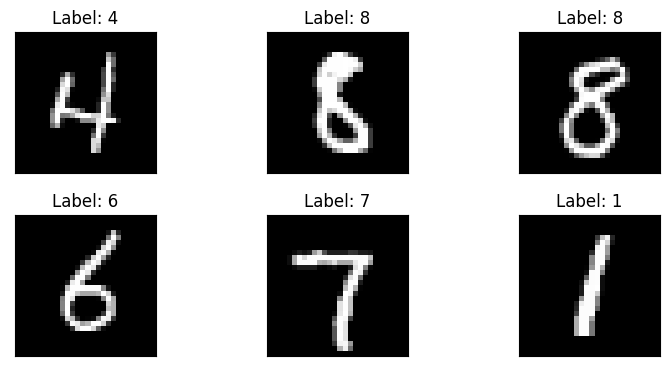

In [6]:
plt.figure(figsize=(8, 4)) 
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title(f"Label: {example_targets[i]}")
    plt.xticks([])
    plt.yticks([])

We can now define the model. The model is a class that inherits from the *nn.Module* class. The *__init__* method defines the layers of the model. The *forward* method defines the forward pass of the model. 

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        pass  

    def forward(self, x):
        pass

In particular, the model has two hidden layers with 64 and 32 neurons, respectively. The hidden layers use the relu activation function. The output layer has 10 neurons and uses the softmax activation function.

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 64)   # Fully connected layer with 784 input features and 64 output features
        self.fc2 = nn.Linear(64, 32)   # Fully connected layer with 64 input features and 32 output features
        self.fc3 = nn.Linear(32, 10)  # Fully connected layer with 32 input features and 10 output features

    def forward(self, x):
        x = x.view(-1, 784) # Reshapes the input tensor to a 1D tensor
        x = F.relu(self.fc1(x)) # Applies the rectified linear unit function to the output of the first fully connected layer
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


We initialize the model and the optimizer. We also define the loss function:

In [9]:
network = Net().cuda() # Instantiates the neural network
optimizer = optim.SGD(network.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss() # Instantiates the loss function

We can count the number of parameters of the model:

In [10]:
model_parameters = filter(lambda p: p.requires_grad, network.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Number of trainable parameters: {params}")

Number of trainable parameters: 52650


Let us observe the output of the model before training:

In [11]:
first_image = example_data[0:1].cuda()
first_target = example_targets[0:1].cuda()
with torch.no_grad():
    print(f"Output shape: {network(first_image).shape}")
    print(f"Output: {network(first_image)}")

Output shape: torch.Size([1, 10])
Output: tensor([[-0.0082, -0.0773,  0.0621,  0.1702, -0.1853,  0.1528,  0.0084,  0.2774,
          0.3845,  0.1428]], device='cuda:0')


The predicted label is the index of the neuron with the highest activation:

In [12]:
print(f"Prediction: {network(first_image).argmax()} vs. Target: {first_target}")

Prediction: 8 vs. Target: tensor([4], device='cuda:0')


If we compute the accuary of the first batch, we obtain:

In [13]:
predictions = network(example_data.cuda()).argmax(dim=1)
number_of_correct_predictions = (predictions == example_targets.cuda()).sum().item()
print(f"Accuracy: {number_of_correct_predictions}/{batch_size_train} ({100*number_of_correct_predictions/batch_size_train:.2f}%)")

Accuracy: 6/100 (6.00%)


The model is not trained yet, so the predictions are random.

For a given batch of the dataset, we will update the parameters using gradient descent with the backpropagation algorithm:
```python
optimizer.zero_grad() # Clears the gradients of all optimized torch.Tensors
output = network(data.cuda()) # Forward pass: computes predicted outputs by passing inputs to the model
loss = criterion(output, target.cuda())  # Computes the loss
loss.backward() # Backward pass: computes gradient of the loss with respect to model parameters
optimizer.step() # Updates the parameters of the model
```

We will apply this loop for every batch of the dataset multiples times:

In [14]:
def train(epoch):
  for batch_idx, (data, target) in enumerate(train_loader): # Iterates over the training dataset
    optimizer.zero_grad() # Clears the gradients of all optimized torch.Tensors
    output = network(data) # Forward pass: computes predicted outputs by passing inputs to the model
    loss = criterion(output, target)  # Computes the loss
    loss.backward() # Backward pass: computes gradient of the loss with respect to model parameters
    optimizer.step() # Updates the parameters of the model

We add a few lines of code to improve the evaluation of the training algorithm:

In [15]:
def train(epoch, log_interval):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader): # Iterates over the training dataset
    optimizer.zero_grad() # Clears the gradients of all optimized torch.Tensors
    output = network(data.cuda()) # Forward pass: computes predicted outputs by passing inputs to the model
    loss = criterion(output, target.cuda())  # Computes the loss
    loss.backward() # Backward pass: computes gradient of the loss with respect to model parameters
    optimizer.step() # Updates the parameters of the model

    if batch_idx % log_interval == 0 or batch_idx == len(train_loader)-1:
        print('Train Epoch: {} [{:5d}/{:5d} ({:3.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_losses.append(loss.item())
    train_counter.append(
            (batch_idx*batch_size_train) + ((epoch-1)*len(train_loader.dataset)))


We can also define a function to evaluate the model on the test set:

In [16]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data.cuda())
      test_loss += criterion(output, target.cuda()).sum()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.cuda().data.view_as(pred)).sum()
  test_losses.append(test_loss.item())
  print('Test set: Average loss: {:.4f},\t Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

We can now train the model:

In [17]:
train_losses,train_counter,  test_losses = [], [], [] 
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

test()
for epoch in range(1, n_epochs + 1):
    train(epoch, 100)
    test()


Test set: Average loss: 2.3118,	 Accuracy: 846/10000 (8%)

Train Epoch: 1 [    0/60000 (  0%)]	Loss: 2.319541
Train Epoch: 1 [10000/60000 ( 17%)]	Loss: 2.287766
Train Epoch: 1 [20000/60000 ( 33%)]	Loss: 2.280313
Train Epoch: 1 [30000/60000 ( 50%)]	Loss: 2.287734
Train Epoch: 1 [40000/60000 ( 67%)]	Loss: 2.268912
Train Epoch: 1 [50000/60000 ( 83%)]	Loss: 2.254742
Train Epoch: 1 [59900/60000 (100%)]	Loss: 2.245768
Test set: Average loss: 2.2522,	 Accuracy: 1537/10000 (15%)

Train Epoch: 2 [    0/60000 (  0%)]	Loss: 2.231626
Train Epoch: 2 [10000/60000 ( 17%)]	Loss: 2.236296
Train Epoch: 2 [20000/60000 ( 33%)]	Loss: 2.231608
Train Epoch: 2 [30000/60000 ( 50%)]	Loss: 2.225644
Train Epoch: 2 [40000/60000 ( 67%)]	Loss: 2.218160
Train Epoch: 2 [50000/60000 ( 83%)]	Loss: 2.193765
Train Epoch: 2 [59900/60000 (100%)]	Loss: 2.170033
Test set: Average loss: 2.1845,	 Accuracy: 2521/10000 (25%)

Train Epoch: 3 [    0/60000 (  0%)]	Loss: 2.192061
Train Epoch: 3 [10000/60000 ( 17%)]	Loss: 2.179559
Tra

In [18]:
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"]})

plt.rcParams['font.size'] = 15
plt.rcParams['legend.framealpha'] = 0.3

We can define a function to plot the training and test losses:

In [19]:
def plot_loss(train_counter, train_losses, test_counter, test_losses):

    plt.figure(figsize=(12, 8))
    plt.annotate('', xy=(0, np.max(train_losses)*1.2), xytext=(0, -0.02),
                    arrowprops=dict(linewidth=2, arrowstyle='->', color='k'), 
                    annotation_clip=False) 
    plt.annotate('', xy=(1.05*max(train_counter), -0.0), xytext=(-100, -0.0),
                    arrowprops=dict(linewidth=2, arrowstyle='->', color='k'), 
                    annotation_clip=False)

    plt.plot(train_counter, train_losses, color='#08457E', clip_on=False)
    plt.ylim([0, np.max(train_losses)*1.2])
    plt.xlim([0, max(train_counter)])
    plt.scatter(test_counter, test_losses, color='#F44336',zorder=+100, clip_on=False)
    plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
    plt.xlim([0, max(train_counter)])
    plt.xlabel('Number of Examples Seen by the model')
    plt.ylabel('Cross-Entropy')
    plt.show()



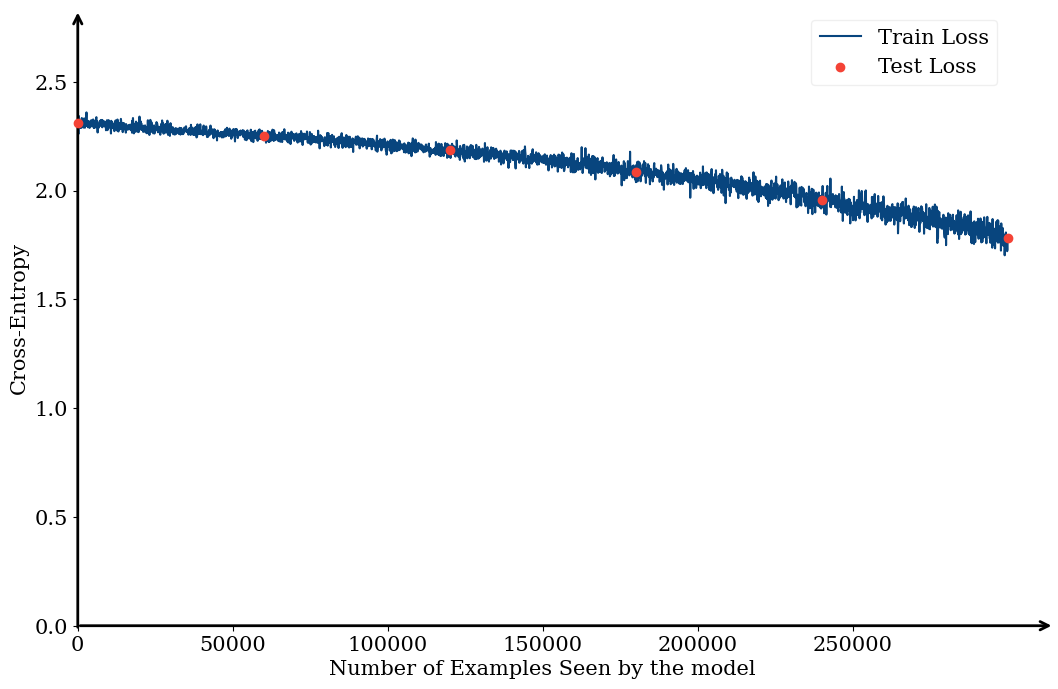

In [20]:
plot_loss(train_counter, train_losses, test_counter, test_losses)

Since the training is long, we can increase the learning rate: 

In [21]:
learning_rate = 0.9 # Learning rate for the optimizer

network = Net().cuda() # Instantiates the neural network
optimizer = optim.SGD(network.parameters(), lr=learning_rate)

In [22]:
train_losses,train_counter,  test_losses = [], [], []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

test()
for epoch in range(1, n_epochs + 1):
    train(epoch, 1000)
    test()

Test set: Average loss: 2.3283,	 Accuracy: 758/10000 (8%)

Train Epoch: 1 [    0/60000 (  0%)]	Loss: 2.319880
Train Epoch: 1 [59900/60000 (100%)]	Loss: 1.490455
Test set: Average loss: 1.3445,	 Accuracy: 5187/10000 (52%)

Train Epoch: 2 [    0/60000 (  0%)]	Loss: 1.353252
Train Epoch: 2 [59900/60000 (100%)]	Loss: 1.857095
Test set: Average loss: 1.7789,	 Accuracy: 2350/10000 (24%)

Train Epoch: 3 [    0/60000 (  0%)]	Loss: 1.791084
Train Epoch: 3 [59900/60000 (100%)]	Loss: 1.898722
Test set: Average loss: 1.7090,	 Accuracy: 2527/10000 (25%)

Train Epoch: 4 [    0/60000 (  0%)]	Loss: 1.754364
Train Epoch: 4 [59900/60000 (100%)]	Loss: 1.540458
Test set: Average loss: 1.6095,	 Accuracy: 3389/10000 (34%)

Train Epoch: 5 [    0/60000 (  0%)]	Loss: 1.632120
Train Epoch: 5 [59900/60000 (100%)]	Loss: 1.860286
Test set: Average loss: 1.7762,	 Accuracy: 2129/10000 (21%)



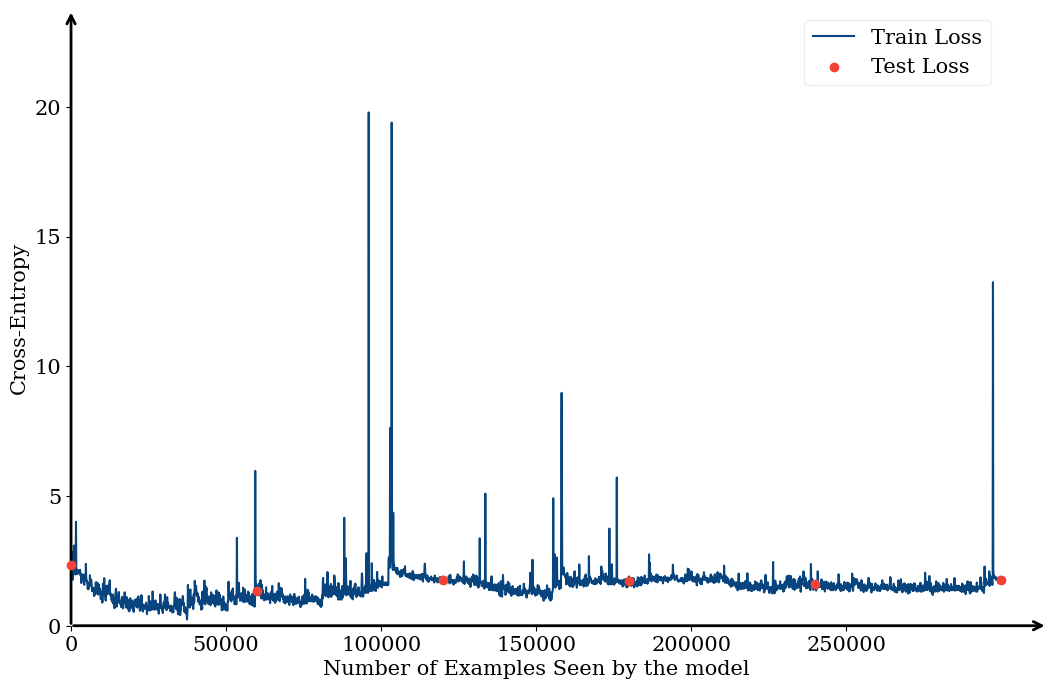

In [23]:
plot_loss(train_counter, train_losses, test_counter, test_losses)

To have a *fast* and *good* training, we must find the right learning rate: 

In [24]:
learning_rate = 5e-2 # Learning rate for the optimizer

network = Net().cuda() # Instantiates the neural network
optimizer = optim.SGD(network.parameters(), lr=learning_rate)

In [25]:
train_losses,train_counter,  test_losses = [], [], []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

test()
for epoch in range(1, n_epochs + 1):
    train(epoch, 1000)
    test()

Test set: Average loss: 2.3157,	 Accuracy: 1009/10000 (10%)

Train Epoch: 1 [    0/60000 (  0%)]	Loss: 2.316067
Train Epoch: 1 [59900/60000 (100%)]	Loss: 0.384729
Test set: Average loss: 0.2376,	 Accuracy: 9275/10000 (93%)

Train Epoch: 2 [    0/60000 (  0%)]	Loss: 0.317440
Train Epoch: 2 [59900/60000 (100%)]	Loss: 0.187381
Test set: Average loss: 0.1667,	 Accuracy: 9509/10000 (95%)

Train Epoch: 3 [    0/60000 (  0%)]	Loss: 0.170198
Train Epoch: 3 [59900/60000 (100%)]	Loss: 0.183906
Test set: Average loss: 0.1368,	 Accuracy: 9584/10000 (96%)

Train Epoch: 4 [    0/60000 (  0%)]	Loss: 0.055773
Train Epoch: 4 [59900/60000 (100%)]	Loss: 0.115236
Test set: Average loss: 0.1222,	 Accuracy: 9615/10000 (96%)

Train Epoch: 5 [    0/60000 (  0%)]	Loss: 0.057502
Train Epoch: 5 [59900/60000 (100%)]	Loss: 0.114205
Test set: Average loss: 0.1100,	 Accuracy: 9659/10000 (97%)



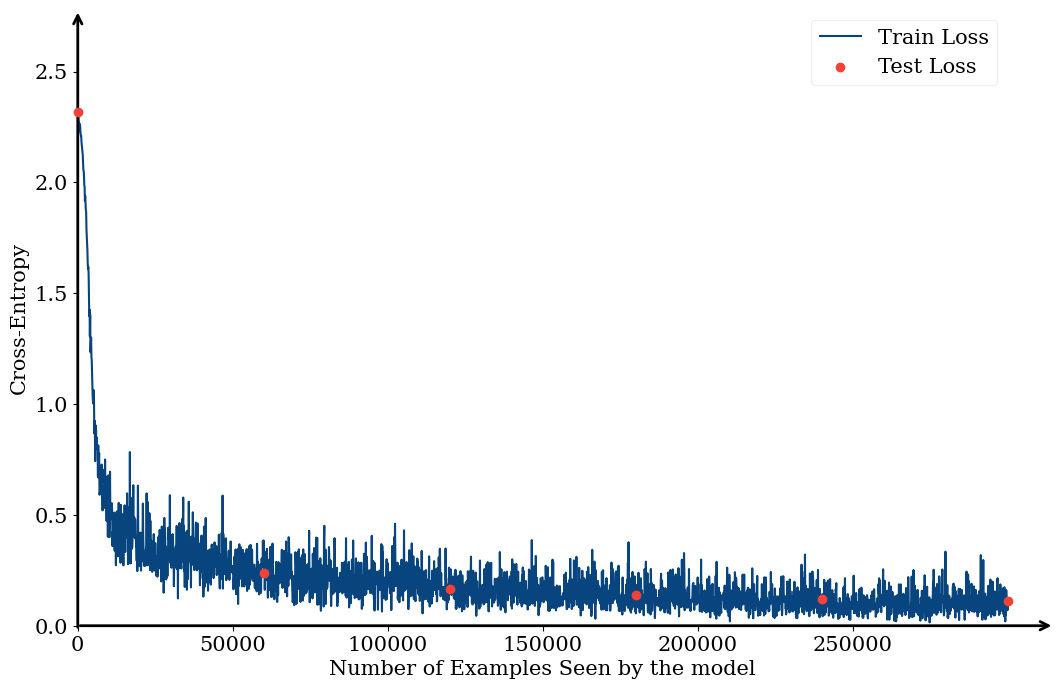

In [26]:
plot_loss(train_counter, train_losses, test_counter, test_losses)

We can now visualize the predictions of the model:

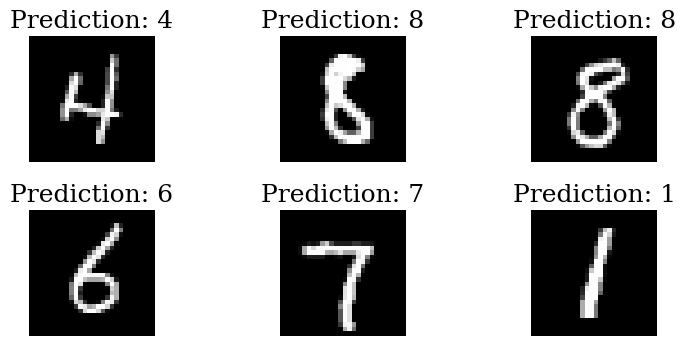

In [27]:
predictions = network(example_data.cuda()).argmax(dim=1)
plt.figure(figsize=(8, 4)) 
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title(f"Prediction: {predictions[i].item()}")
    plt.xticks([])
    plt.yticks([])